This jupyter notebook was first used to figure out how QAOA worked. It generally is just filled with various similar non-isomorphic graphs being compared to each other. This was the first step for what I worked on with the neural network and gave me the idea to use a convolutional NN. I urge the viewer to go through and make observations about the graphs being compared to each other.

In [3]:
import networkx as nx
import random as rand
import matplotlib.pyplot as plt

In [4]:
def DrawGraph(Graph):
    plt.rcParams["figure.figsize"] = (10,6)
    pos=nx.spring_layout(Graph) 
    nx.draw_networkx(Graph,pos)
    labels = nx.get_edge_attributes(Graph,'weight')
    nx.draw_networkx_edge_labels(Graph,pos,edge_labels=labels)
    plt.show()
    return 

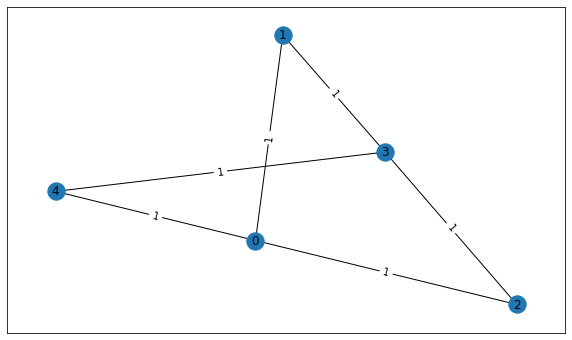

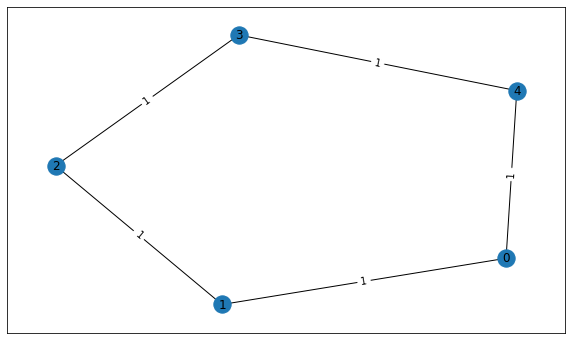

In [54]:
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3,4])
graph.add_edges_from([(0, 1), (1, 3), (2, 3), (3, 4),(4,0),(0,2)])

graph2 = nx.Graph()
graph2.add_nodes_from([0, 1, 2, 3,4])
graph2.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4),(4,0)])

for (u,v,w) in graph.edges(data=True):                                  
    w['weight'] = 1
    
for (u,v,w) in graph2.edges(data=True):                                  
    w['weight'] = 1
    
DrawGraph(graph)
DrawGraph(graph2)


In [55]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter

def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1*graph[i][j]['weight']
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2
    #print(theta)  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(graph[pair[0]][pair[1]]['weight']*2*gamma[layer_index], pair[0], pair[1])
            #print(gamma[layer_index])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    #if I want to run on the quantum computer then I can set backend to a channel for it. Do this instead of qasm_simulator
    # provider = IBMQ.get_provider(hub='ibm-q')
    # backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
    #                                     and not x.configuration().simulator 
    #                                     and x.status().operational==True))
    #tell us what the least busy one is
   #print("least busy backend: ", backend) 
    backend.shots = shots

    def execute_circ(theta):
        #print(theta)
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [56]:
from scipy.optimize import minimize
expectation = get_expectation(graph)
res = minimize(expectation,
               [1,1],
               method='COBYLA')
res

     fun: -3.6728515625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 32
  status: 1
 success: True
       x: array([ 3.46156356, -0.3200745 ])

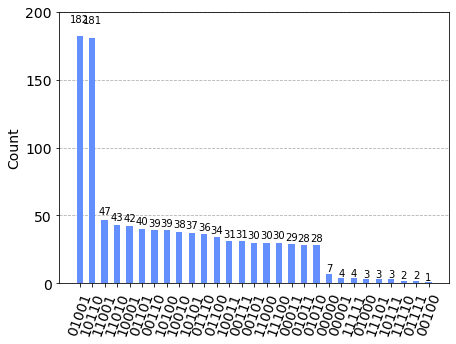

In [ ]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(graph, res.x)
#print(res.fun)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts,sort='value_desc')
#try not to order the binary solutions, they are usually ordered from 0-2^n where n is the number of nodes instead of the greatest expectated value.



In [20]:
expectation = get_expectation(graph2)
res = minimize(expectation,
               [1,1],
               method='COBYLA')
res
#fun tells us the expectated maximum number of cuts in the system. The closer it is to the true value the better and more likely the highest expectated value is going to be the true optimized solution.

     fun: -3.744140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 32
  status: 1
 success: True
       x: array([1.96991273, 1.16688172])

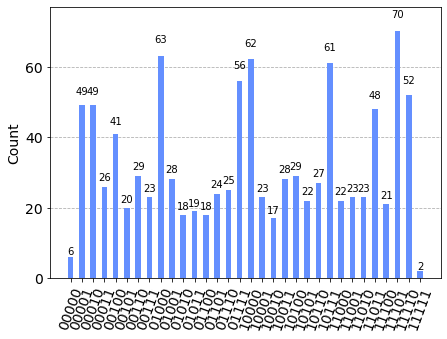

In [21]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512
from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(graph, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

Notice the the graph has symmetry with 0/1. For instance, 0000 is practically the same as 1111 and 01111 is the same as 10000. This gives rise to why I combined the ends in the Data Production.

In [1]:
import networkx as nx
import random as rand
import matplotlib.pyplot as plt
from qiskit import Aer, execute

This is where I import the file of all the different types of connected graphs with 5 vertices.

In [2]:
G = nx.read_graph6("graph5c.g6")
graph2 = nx.Graph()
graph2.add_nodes_from([0,1, 2, 3,4,5,6,7])
graph2.add_edges_from([(0,7),(0,5),(0,6),(6,1),(1,4),(2,6),(2,3)])
G.append(graph2)

In [3]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
def DrawGraph(Graph):
    plt.rcParams["figure.figsize"] = (10,6)
    pos=nx.spring_layout(Graph) 
    nx.draw_networkx(Graph,pos)
    labels = nx.get_edge_attributes(Graph,'weight')
    nx.draw_networkx_edge_labels(Graph,pos,edge_labels=labels)
    plt.show()
    return 
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
         # problem unitary
        
            
    qc.measure_all()
        
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(G, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [4]:
from scipy.optimize import minimize
import numpy as np
expectation=[]
res=[]
for x in range(0,len(G)):
    expectation.append(get_expectation(G[x]))
    res.append(minimize(expectation[x],
               [1,1,1,1],
               method='COBYLA'))

In [5]:
from qiskit.visualization import plot_histogram
qc_res=[]
counts=[]
backend = Aer.get_backend('aer_simulator')
backend.shots = 1024
for i in range(0,len(G)):
    qc_res.append(create_qaoa_circ(G[i], res[i].x))
    counts.append(backend.run(qc_res[i], seed_simulator=10).result().get_counts())
    for state in counts[i]:
        counts[i][state]=counts[i][state]/backend.shots


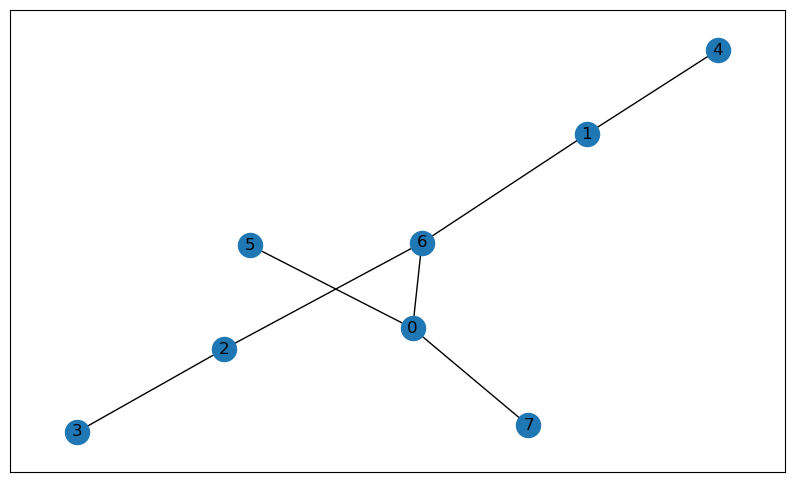

res: 21

  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.302734375
       x: [ 1.232e+00  1.888e+00  1.340e+00  1.281e+00]
    nfev: 61
   maxcv: 0.0
{'11011001': 0.0087890625, '11001000': 0.001953125, '10111001': 0.0029296875, '11111110': 0.0009765625, '01100101': 0.0009765625, '11110101': 0.00390625, '10101110': 0.0126953125, '11110000': 0.0087890625, '01011001': 0.04296875, '00010101': 0.037109375, '10110000': 0.005859375, '11010000': 0.005859375, '00001111': 0.009765625, '01111000': 0.01953125, '10111000': 0.0078125, '01110111': 0.0009765625, '01001011': 0.0107421875, '11000011': 0.0009765625, '11101010': 0.0400390625, '10111110': 0.001953125, '01010000': 0.0009765625, '00000110': 0.0048828125, '10101100': 0.001953125, '01111001': 0.0087890625, '11000101': 0.001953125, '00001011': 0.0458984375, '01001010': 0.0009765625, '01110100': 0.005859375, '00100111': 0.015625, '10100110': 0.0419921875, '01001000': 0.001953125, '10100111': 0.0078125, '0

In [6]:
# for i in range(0,len(G)):
#     print("Graph:",i)
#     DrawGraph(G[i])for i in {0,1,2,3}:
DrawGraph(G[21])
print("res:",21)
print("\n",res[21])
plot_histogram([counts[21]], color=['crimson','blue','green','black'],bar_labels =False,
                title="Graph 6v7")
print(counts[21])

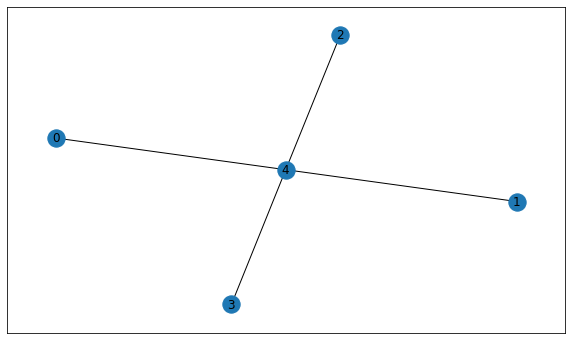

res: 0

      fun: -3.3671875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 56
  status: 1
 success: True
       x: array([2.18944121, 2.80824966, 2.58619   , 0.76260903])


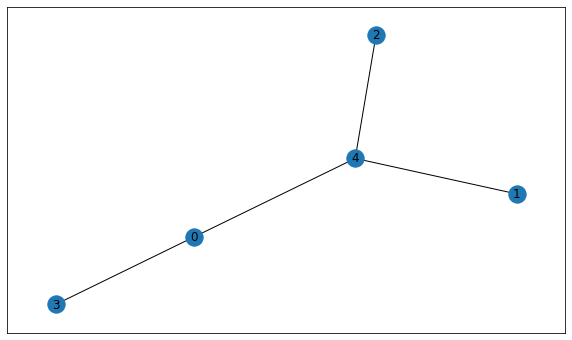

res: 1

      fun: -3.072265625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 53
  status: 1
 success: True
       x: array([1.04199831, 1.95100169, 1.41111832, 1.19320756])


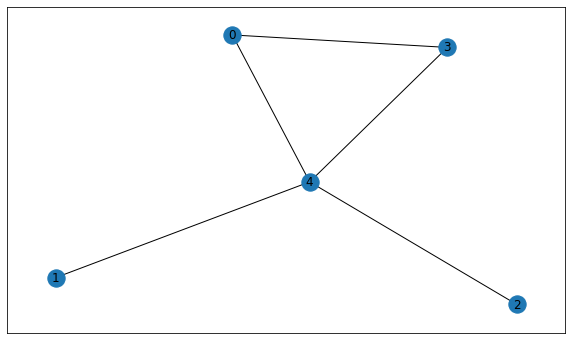

res: 2

      fun: -3.400390625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 48
  status: 1
 success: True
       x: array([1.78541574, 1.79820159, 2.45441976, 0.44450604])


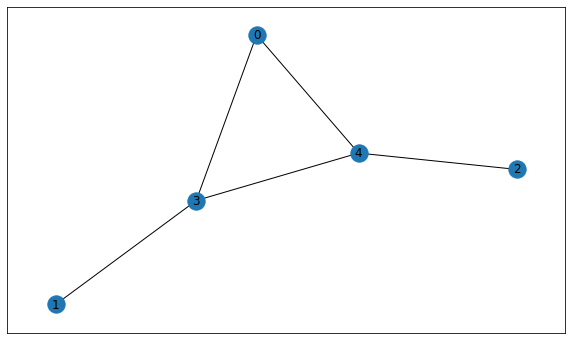

res: 3

      fun: -3.720703125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 56
  status: 1
 success: True
       x: array([1.89373254, 1.82146877, 1.89303062, 0.80249887])


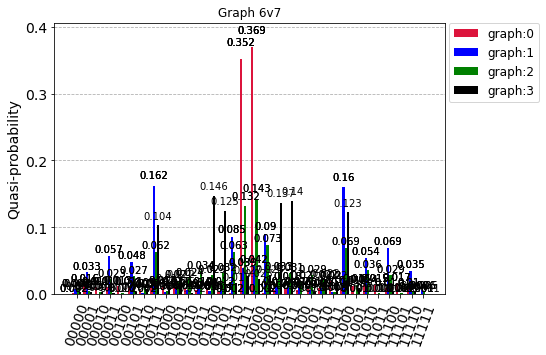

In [30]:
for i in {0,1,2,3}:
    DrawGraph(G[i])
    print("res:",i)
    print("\n",res[i])
legend = ['graph:0', 'graph:1','graph:2','graph:3']
plot_histogram([counts[0],counts[1],counts[2],counts[3]],legend=legend, color=['crimson','blue','green','black'],
                title="Graph 6v7")

Notice the in the above bar graph that the non-isomorphic graphs share similarities. The more you change it the more it changes. Graph 0 and graph 2 share close similarities and are the closest while graph 1 shares more similarities to grpah 3.

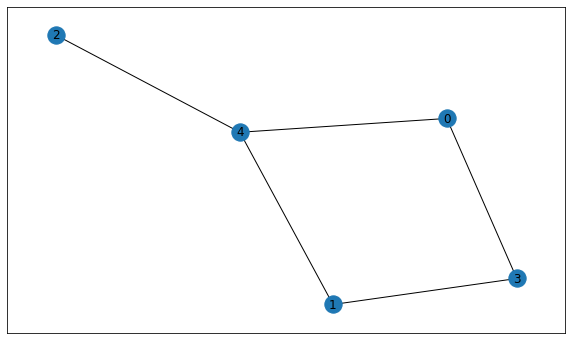

res: 4

      fun: -3.8779296875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 54
  status: 1
 success: True
       x: array([1.40866829, 1.98932398, 2.0475031 , 0.73239527])


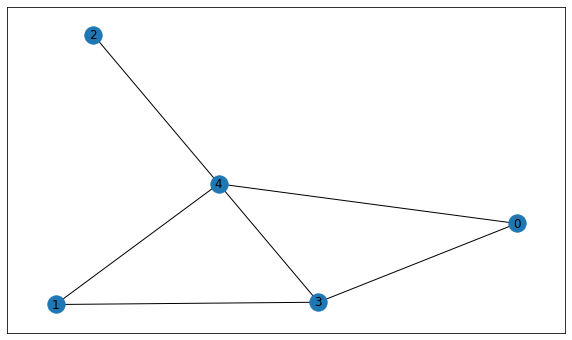

res: 5

      fun: -3.4716796875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 57
  status: 1
 success: True
       x: array([2.15012783, 0.73567702, 0.54244168, 0.87726831])


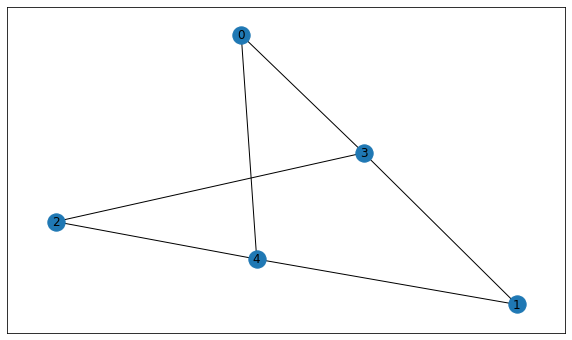

res: 6

      fun: -4.59765625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 50
  status: 1
 success: True
       x: array([2.1534188 , 1.07201389, 1.09513755, 0.88629794])


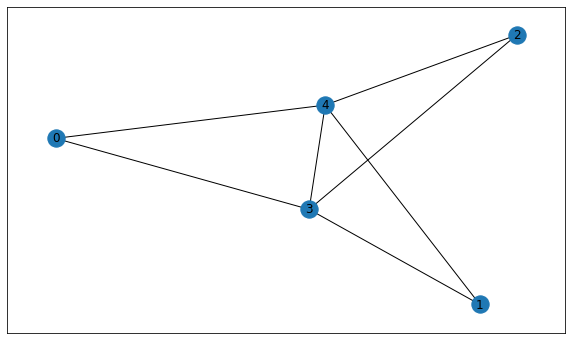

res: 7

      fun: -4.9765625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 49
  status: 1
 success: True
       x: array([2.06256887, 2.18648827, 1.07408243, 0.98939307])


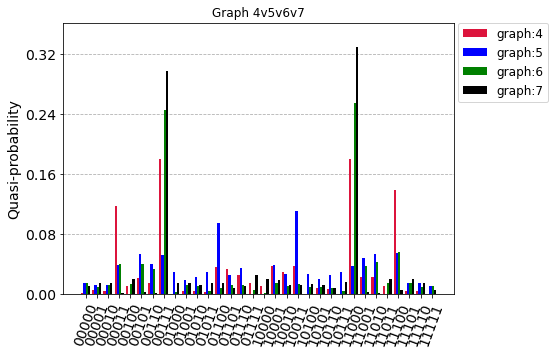

In [31]:
for i in {4,5,6,7}:
    DrawGraph(G[i])
    print("res:",i)
    print("\n",res[i])
legend = ['graph:4', 'graph:5','graph:6','graph:7']
plot_histogram([counts[4],counts[5],counts[6],counts[7]],legend=legend, color=['crimson','blue','green','black'],bar_labels =False,
                title="Graph 4v5v6v7")

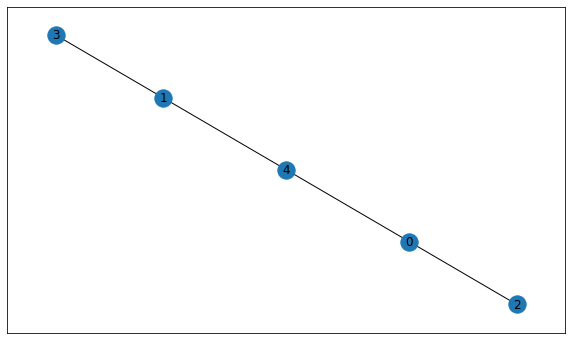

res: 8

      fun: -3.365234375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 58
  status: 1
 success: True
       x: array([1.33724518, 2.09023303, 2.30631113, 0.42250449])


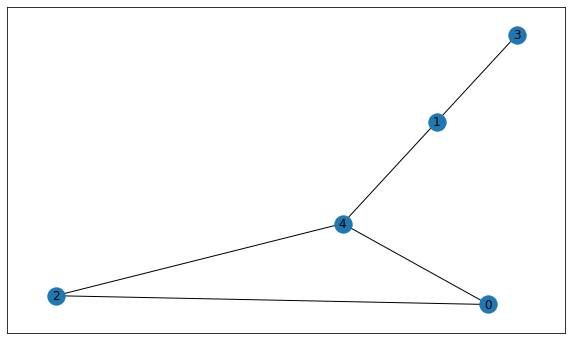

res: 9

      fun: -3.2548828125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 48
  status: 1
 success: True
       x: array([1.07276447, 1.11031008, 1.05727388, 2.18038436])


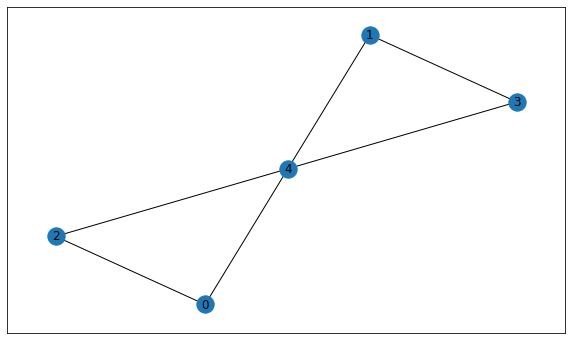

res: 10

      fun: -3.955078125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 51
  status: 1
 success: True
       x: array([ 2.25035189,  2.10309917,  1.86073553, -0.05107449])


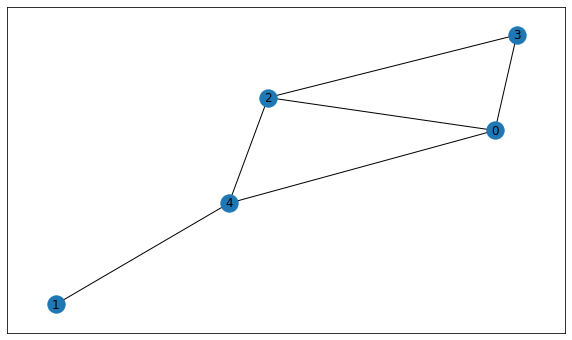

res: 11

      fun: -3.9990234375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 57
  status: 1
 success: True
       x: array([1.18400924, 1.81671284, 1.30125682, 1.00931386])


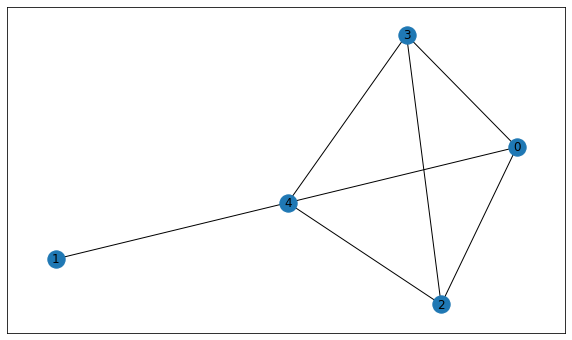

res: 12

      fun: -4.3984375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 41
  status: 1
 success: True
       x: array([1.45950733, 1.91082915, 1.98608142, 0.92059794])


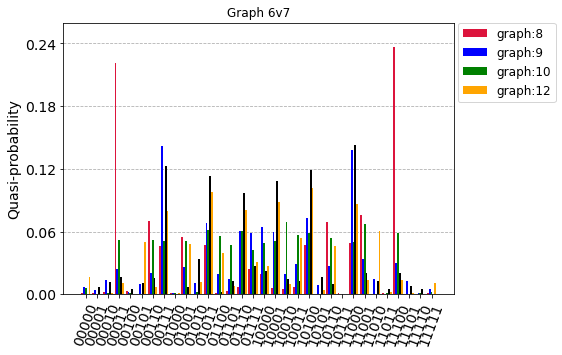

In [33]:
for i in {8,9,10,11,12}:
    DrawGraph(G[i])
    print("res:",i)
    print("\n",res[i])
legend = ['graph:8', 'graph:9','graph:10','graph:11','graph:12']
plot_histogram([counts[8],counts[9],counts[10],counts[11],counts[12]],legend=legend, color=['crimson','blue','green','black','orange'],bar_labels =False,
                title="Graph 6v7")

We see what I explained previously in a better example. Sometimes a addition of a edge can result in a different optimal solution but still shares similarities to what it was before. Example: graph 8 still shows increase probability for the expected values of graph 9 and 11

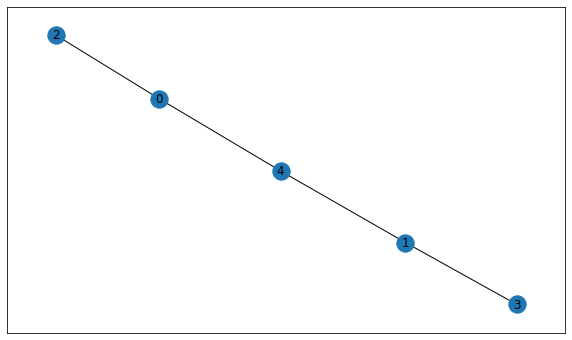

res: 8

      fun: -3.365234375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 58
  status: 1
 success: True
       x: array([1.33724518, 2.09023303, 2.30631113, 0.42250449])


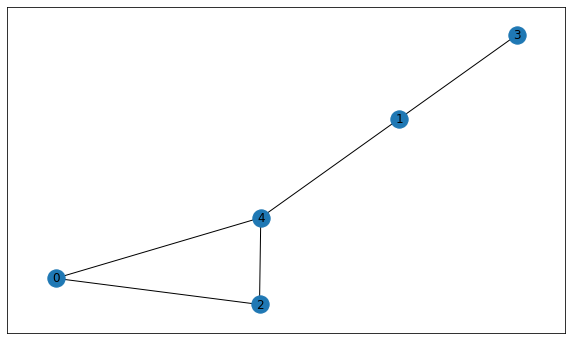

res: 9

      fun: -3.2548828125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 48
  status: 1
 success: True
       x: array([1.07276447, 1.11031008, 1.05727388, 2.18038436])


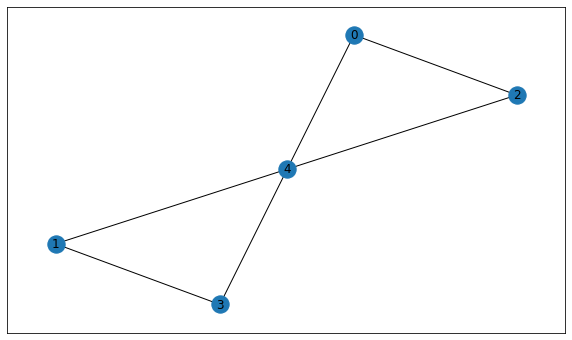

res: 10

      fun: -3.955078125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 51
  status: 1
 success: True
       x: array([ 2.25035189,  2.10309917,  1.86073553, -0.05107449])


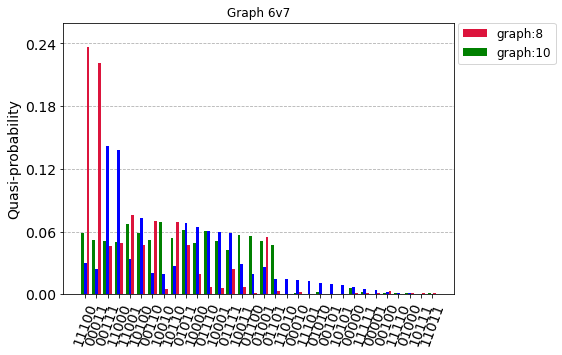

In [35]:
for i in {8,9,10}:
    DrawGraph(G[i])
    print("res:",i)
    print("\n",res[i])
legend = ['graph:8', 'graph:9','graph:10']
plot_histogram([counts[8],counts[9],counts[10]],legend=legend, color=['crimson','blue','green','black','orange'],sort='value_desc',bar_labels =False,
                title="Graph 6v7")

This is interesting because the switch from graph 8 to 9 caused the distribution to keep a similar shape but the be shifted over.

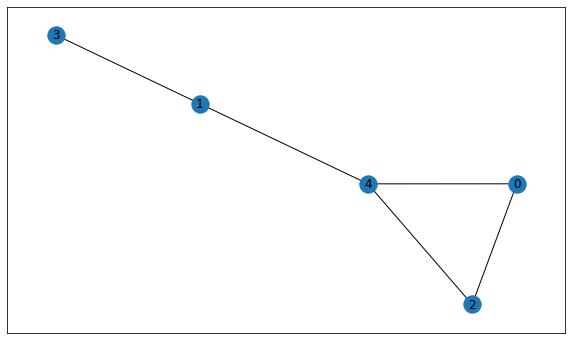

res: 9

      fun: -3.2548828125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 48
  status: 1
 success: True
       x: array([1.07276447, 1.11031008, 1.05727388, 2.18038436])


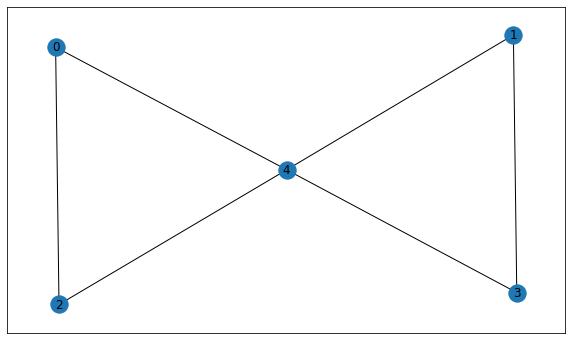

res: 10

      fun: -3.955078125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 51
  status: 1
 success: True
       x: array([ 2.25035189,  2.10309917,  1.86073553, -0.05107449])


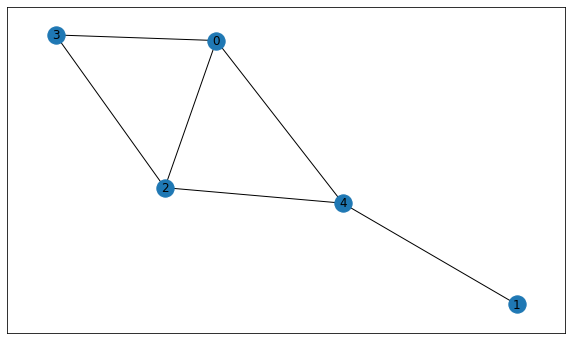

res: 11

      fun: -3.9990234375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 57
  status: 1
 success: True
       x: array([1.18400924, 1.81671284, 1.30125682, 1.00931386])


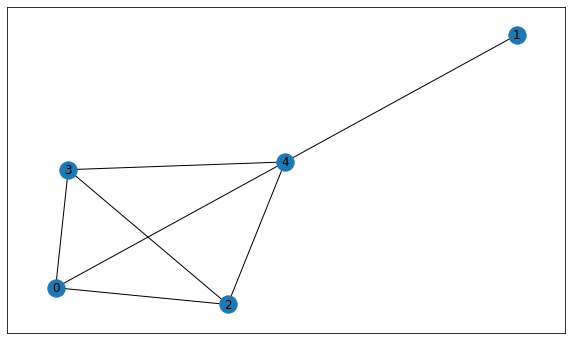

res: 12

      fun: -4.3984375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 41
  status: 1
 success: True
       x: array([1.45950733, 1.91082915, 1.98608142, 0.92059794])


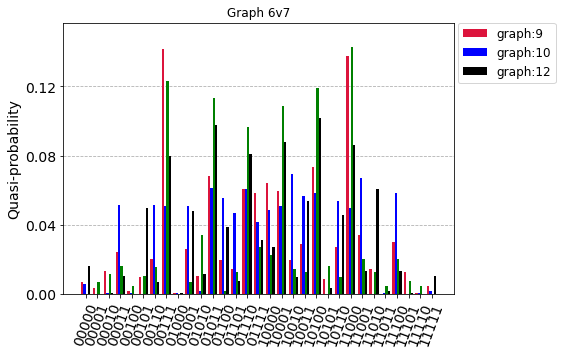

In [33]:
for i in {9,10,11,12}:
    DrawGraph(G[i])
    print("res:",i)
    print("\n",res[i])
legend = [ 'graph:9','graph:10','graph:11','graph:12']
plot_histogram([counts[9],counts[10],counts[11],counts[12]],legend=legend, color=['crimson','blue','green','black','orange'],bar_labels=False,
                title="Graph 6v7")

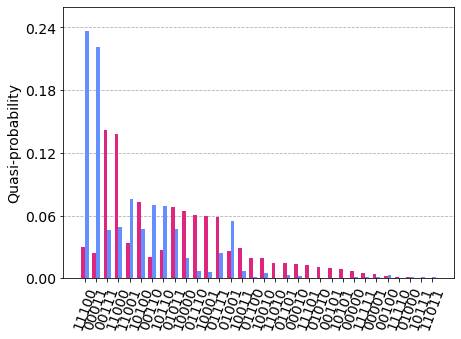

In [38]:

plot_histogram([counts[8],counts[9]],bar_labels=False,sort='value_desc')

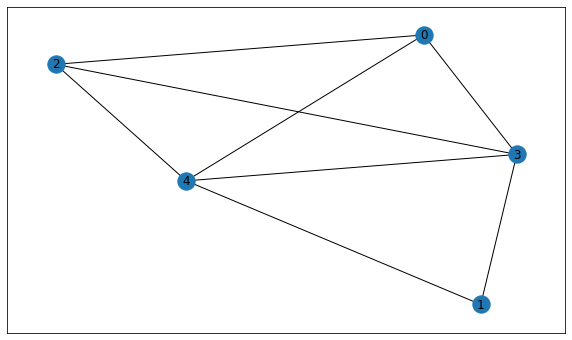

res: 16

      fun: -4.6494140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.0079699 , 0.93608925])


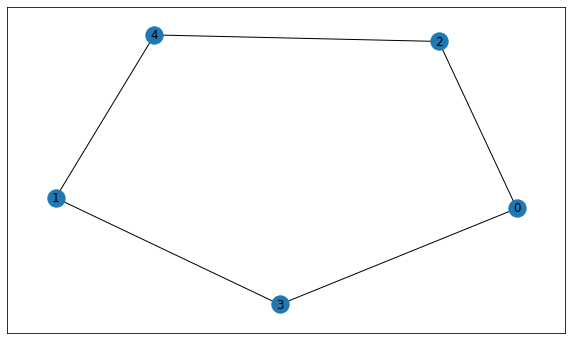

res: 13

      fun: -3.841796875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 39
  status: 1
 success: True
       x: array([2.88894897, 0.25266802])


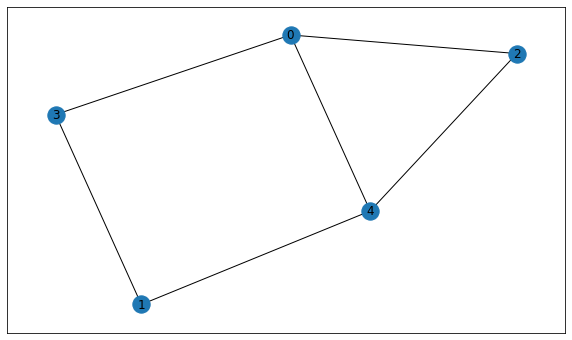

res: 14

      fun: -4.205078125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 27
  status: 1
 success: True
       x: array([0.41561694, 2.73075643])


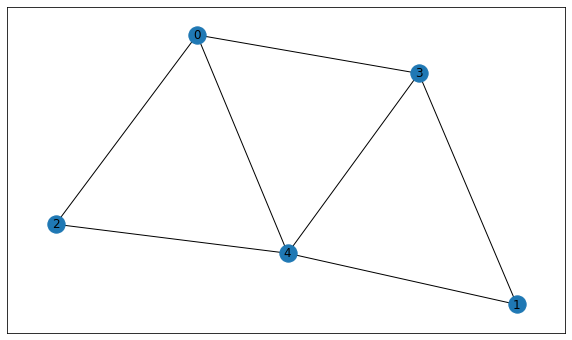

res: 15

      fun: -4.1201171875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([1.02110193, 2.03629205])


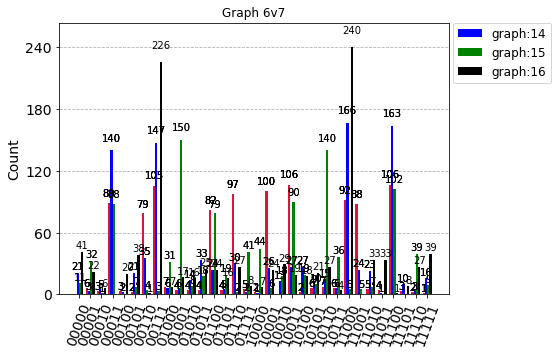

In [37]:
for i in {13,14,15,16}:
    DrawGraph(G[i])
    print("res:",i)
    print("\n",res[i])
legend = [ 'graph:13','graph:14','graph:15','graph:16']
plot_histogram([counts[13],counts[14],counts[15],counts[16]],legend=legend, color=['crimson','blue','green','black','orange'],
                title="Graph 6v7")

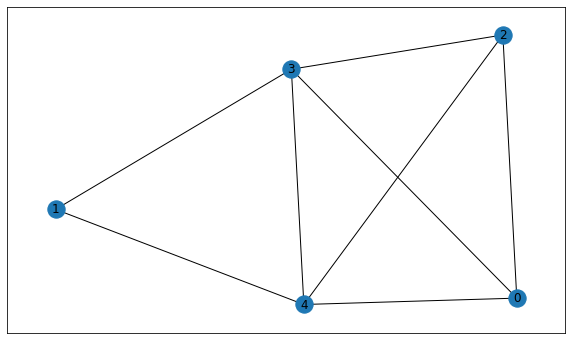

res: 16

      fun: -4.6494140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.0079699 , 0.93608925])


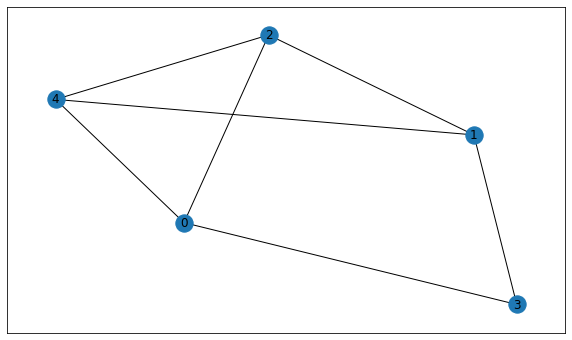

res: 17

      fun: -4.412109375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 37
  status: 1
 success: True
       x: array([ 4.26787371, -1.4212938 ])


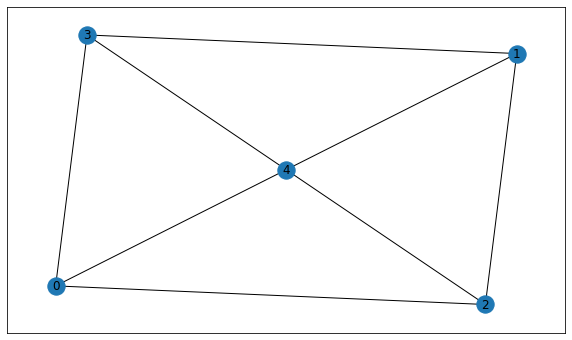

res: 18

      fun: -5.1416015625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([2.918308  , 0.20588186])


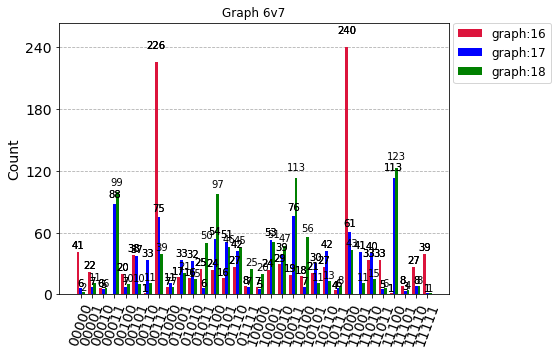

In [38]:
for i in {16,17,18}:
    DrawGraph(G[i])
    print("res:",i)
    print("\n",res[i])
legend = ['graph:16','graph:17','graph:18']
plot_histogram([counts[16],counts[17],counts[18]],legend=legend, color=['crimson','blue','green','black','orange'],
                title="Graph 6v7")

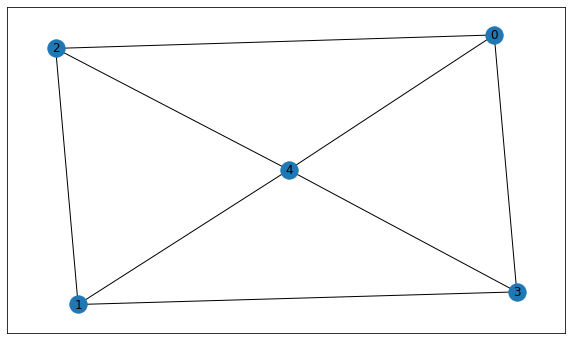

res: 18

      fun: -5.1416015625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([2.918308  , 0.20588186])


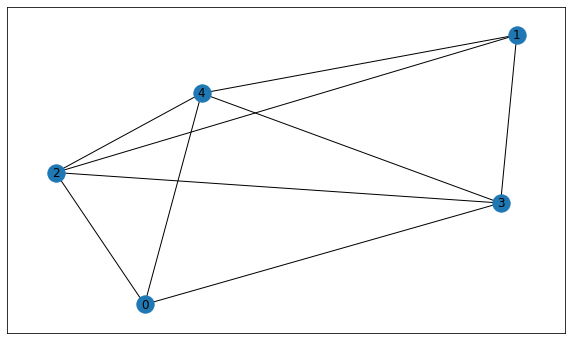

res: 19

      fun: -4.716796875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 28
  status: 1
 success: True
       x: array([1.94232273, 0.98244872])


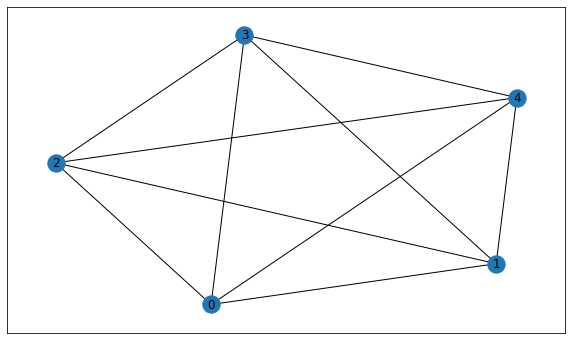

res: 20

      fun: -5.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array([1.94491881, 1.03470165])


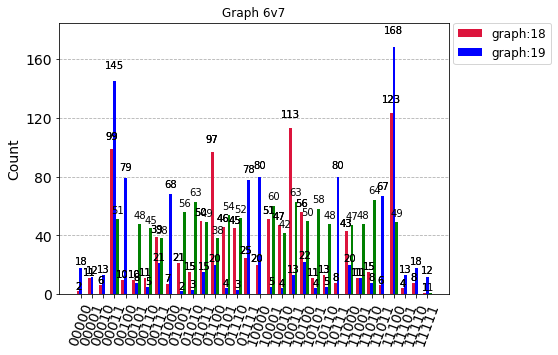

In [39]:
for i in {18,19,20}:
    DrawGraph(G[i])
    print("res:",i)
    print("\n",res[i])
legend = ['graph:18','graph:19','graph:20']
plot_histogram([counts[18],counts[19],counts[20]],legend=legend, color=['crimson','blue','green','black','orange'],
                title="Graph 6v7")

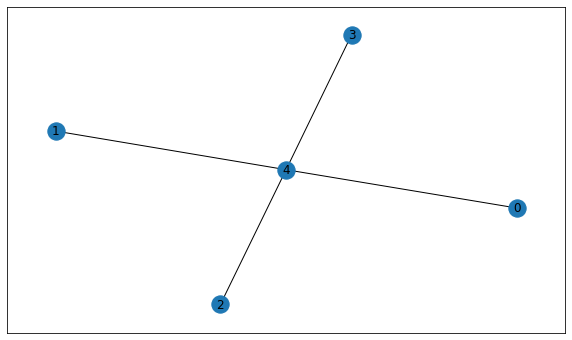

res: 0

      fun: -3.5556640625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([2.79980851, 0.48018295])


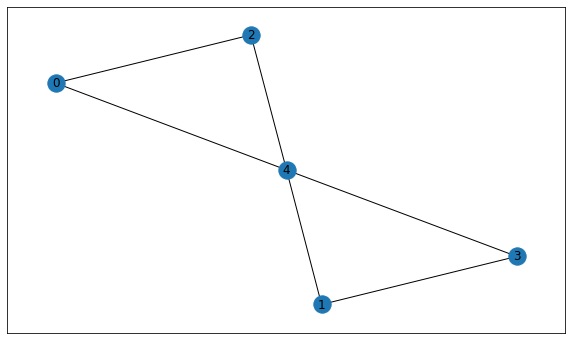

res: 10

      fun: -3.5390625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.96948399, 0.81137041])


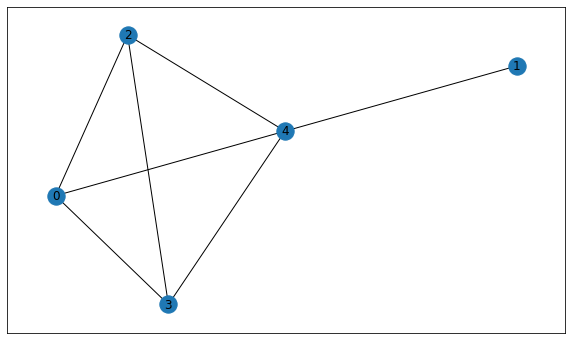

res: 12

      fun: -3.9482421875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 31
  status: 1
 success: True
       x: array([2.184901  , 0.86950379])


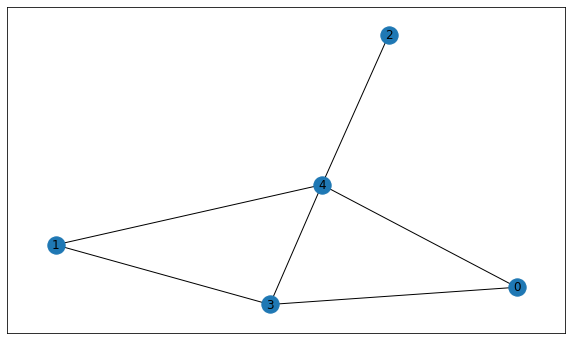

res: 5

      fun: -3.837890625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 34
  status: 1
 success: True
       x: array([3.58607292, 2.70376725])


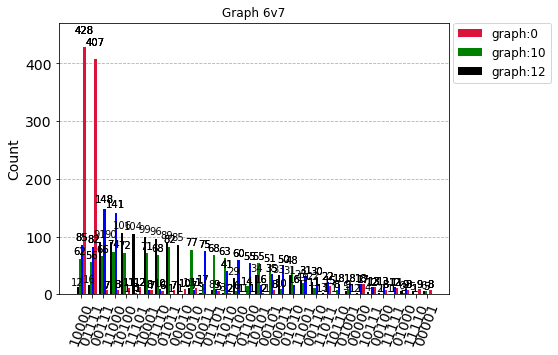

In [40]:
for i in {0,5,10,12}:
    DrawGraph(G[i])
    print("res:",i)
    print("\n",res[i])
legend = ['graph:0','graph:5','graph:10','graph:12']
plot_histogram([counts[0],counts[5],counts[10],counts[12]],legend=legend, color=['crimson','blue','green','black','orange'], sort='value_desc',
                title="Graph 6v7")